In [8]:
from tools_harassment import * 
from transformer_class_SMOTE import *
from models import *
import torch 
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
import gc
from imblearn.over_sampling import SMOTE
import pandas as pd
import gc
import seaborn 


keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


keys=["commenting", "support", "denying", "questioning"]


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'


There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [9]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)
    
    
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################"""
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [10]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [11]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [12]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
#class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.0, 1.0, 1.0, 1.0]


In [13]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [14]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [15]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [16]:
x_train=np.zeros((shape[0], emb))
i=0
for in_id in input_ids:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    if n==0:
        x_train[i]=vector
        i+=1
        continue
        
    else:
        for idv in in_id:
            if idv!=0:
                vector+=EMB_matrix[idv]
        x_train[i]=(vector/n)
        i+=1   
    
x_val=np.zeros((shape_val[0], emb))
i=0
for in_id in input_ids_val:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=EMB_matrix[idv]
    x_val[i]=(vector/n)
    i+=1  
    
x_test=np.zeros((shape_test[0], emb))
i=0
for in_id in input_ids_test:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=EMB_matrix[idv]
    x_test[i]=(vector/n)
    i+=1  

In [17]:
x_train.shape

(6374, 200)

In [18]:
x_test.shape

(2123, 200)

In [19]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas


In [20]:
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size,mode,n_machines,new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings, etiq, etiq_v):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)    
        labels=etiq
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    #print ("los indices de train k voy a acceder random son", x_data[0])
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        #print ("transformando batch", batch)
        temp=[]
        for pos in batch:
            #print("en especifico el numerito", pos)
            temp2=[index_embeddings[pos+5]]#fromId2num[objs[exam]]] ### obj evaluado en maquinas  
            #print ("me dice que es el embed en index", temp2)
            for m in range(n_machines): 
                #print ("machine ",m,"dice:", np.argmax(new_matrix[m][pos])+1)
                temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
                #matrix[4][cosa-5])+1)
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            #print ("OUT DE RUN EPOCH", out)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last


def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

In [21]:
etiq_v= n_labels_val
etiq_t= n_labels_test

In [31]:
def train_5models_smote(e1, e2, x_val, y_val, xfrom, xto, task, num_epochs, c_gama):
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    
    best_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}
    norm_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}
    voting_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}
    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    best_macro={'F_ma':0.1 , 'Run':0}
    
    if task== 'Stance':
        path='../../Datasets/Models_Stance/SMOTE'
    elif task== 'Harassment':
        path= '../../Datasets/Models_Harassment/SMOTE'
        
    bs=32
    n_machines=5
    
    keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

    
    for x in range(xfrom,xto + 1):    
        sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
        x_train_smote, y_train_smote = sm.fit_sample(np.asarray(x_train, dtype='float32'), np.asarray(n_labels, dtype='float32'))


        x_new_train=np.expand_dims(x_train_smote, axis=-1)
        x_new_val=np.expand_dims(x_val, axis=-1)
        x_new_test=np.expand_dims(x_test, axis=-1)

        y_train=to_categorical(y_train_smote,num_classes=4)

        class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_smote), y_train_smote)
        print ("class_weights Training set", class_weights)
            
        
        print ("\n\n -------------------- Entrenando SMOTE exec", x," ------------------- \n\n")
        cnn1=create_cnn1(x_new_train.shape[1:])
        cnn1, hist =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        #cnn1.save(path+'/cnn1_'+str(x)+'-exec_smote.h5')  
        predicciones_all.append(cnn1.predict(x_new_train, batch_size=bs))
        predicciones_all_val.append(cnn1.predict(x_new_val, batch_size=bs))
        predicciones_all_test.append(cnn1.predict(x_new_test, batch_size=bs))
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_new_train, x_new_val, x_new_test, y_train_smote, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()  
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        cnn2=create_cnn2(x_new_train.shape[1:])
        cnn2, hist =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        #cnn2.save(path+'/cnn2_'+str(x)+'-exec_smote.h5')
        predicciones_all.append(cnn2.predict(x_new_train, batch_size=bs))
        predicciones_all_val.append(cnn2.predict(x_new_val, batch_size=bs))
        predicciones_all_test.append(cnn2.predict(x_new_test, batch_size=bs))
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_new_train, x_new_val, x_new_test, y_train_smote, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        rnn1=create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
        rnn1, hist =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        #rnn1.save(path+'/rnn1_'+str(x)+'-exec_smote.h5')
        predicciones_all.append(rnn1.predict(x_new_train, batch_size=bs))
        predicciones_all_val.append(rnn1.predict(x_new_val, batch_size=bs))
        predicciones_all_test.append(rnn1.predict(x_new_test, batch_size=bs))
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_new_train, x_new_val, x_new_test, y_train_smote, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        rnn2=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
        rnn2, hist =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        #rnn2.save(path+'/rnn2_'+str(x)+'-exec_smote.h5')
        predicciones_all.append(rnn2.predict(x_new_train, batch_size=bs))
        predicciones_all_val.append(rnn2.predict(x_new_val, batch_size=bs))
        predicciones_all_test.append(rnn2.predict(x_new_test, batch_size=bs))
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_new_train, x_new_val, x_new_test, y_train_smote, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        rnn3=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
        rnn3, hist =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        #rnn3.save(path+'/rnn3_'+str(x)+'-exec_smote.h5')
        predicciones_all.append(rnn3.predict(x_new_train, batch_size=bs))
        predicciones_all_val.append(rnn3.predict(x_new_val, batch_size=bs))
        predicciones_all_test.append(rnn3.predict(x_new_test, batch_size=bs))
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_new_train, x_new_val, x_new_test, y_train_smote, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

        ######################################
        ######################################
        ######################################
        
        list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
        index_models=np.arange(5)
        dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
        modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
        ind=np.arange(5)
        dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

        print ("\n--------------------------------------------------------")
        print ("Trabajando en predicciones Test - Máquinas de Comité")
        print ("--------------------------------------------------------\n")
        
        
        predichos_all_test_copia=predicciones_all_test.copy()
        predichos_all_test_copia=np.concatenate(np.asarray(predichos_all_test_copia),axis=-1)

        print ("\nEvaluating Committee Best Fit...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos(bs,predichos_all_test_copia)
        acc_comite= accuracy_score(n_labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(n_labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(n_labels_test, trainPredicho, average=None)
        np.set_printoptions(precision=3)
        print("F1-score NIPS:",f1_no)
        cm=cm_norma(confusion_matrix(n_labels_test, trainPredicho))
        best_test['acc'].append(acc_comite)
        best_test['macro'].append(f1)
        best_test['none'].append(f1_no)
        best_test['cm'].append(cm)

        print ("\nEvaluating Committee Norm...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos_norm(bs,predichos_all_test_copia)
        acc_comite= accuracy_score(n_labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(n_labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(n_labels_test, trainPredicho, average=None) 
        np.set_printoptions(precision=3)
        print("F1-score NIPS:",f1_no)
        cm=cm_norma(confusion_matrix(n_labels_test, trainPredicho))
        norm_test['acc'].append(acc_comite)
        norm_test['macro'].append(f1)
        norm_test['none'].append(f1_no)
        norm_test['cm'].append(cm)
        
        print ("\nEvaluating Committee Voting...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos_average(bs,predichos_all_test_copia)
        acc_comite= accuracy_score(n_labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(n_labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(n_labels_test, trainPredicho, average=None) 
        np.set_printoptions(precision=3)
        print("F1-score NIPS:",f1_no)
        cm=cm_norma(confusion_matrix(n_labels_test, trainPredicho))
        voting_test['acc'].append(acc_comite)
        voting_test['macro'].append(f1)
        voting_test['none'].append(f1_no)
        voting_test['cm'].append(cm)
        
        keras.backend.clear_session()
        gc.collect()
        
        
        
        ################# TRANSFORMER    
        print ("\n--------------------------------------------------------")
        print ("Trabajando en predicciones Transformer")
        print ("--------------------------------------------------------\n")
        

        #for i in dict_trainedModel.keys(): 
        #    predicciones_all.append(dict_trainedModel[i].predict(x_new_train, batch_size=bs))
        #for i in dict_trainedModel.keys(): 
        #    predicciones_all_val.append(dict_trainedModel[i].predict(x_new_val, batch_size=bs))
        #for i in dict_trainedModel.keys(): 
        #    predicciones_all_test.append(dict_trainedModel[i].predict(x_new_test, batch_size=bs))

        matrix=np.asarray(predicciones_all)
        matrix_val=np.asarray(predicciones_all_val)
        matrix_test=np.asarray(predicciones_all_test)
        new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)

        
        espacio=[np.ones(emb)]
        Ks= ortho_group.rvs(dim=emb)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']

        for i in range(len(x_new_train)):
            clase=dict_cl[y_train_smote[i]]   
            final_bert= x_train_smote[i]

            index_embeddings.append(i+5)
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)

        objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
        objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])

        for num in range(len(llaves)):
            clase=clases[num]
            tw_tr=sent_all[num]
            tokens_valid = cleaner(tw_tr)[1]  #cleaner: raw, no cleaner:augmented version
            
            trans=[]
            for wd in tokens_valid:
                try:
                    trans.append(token_2_idx[wd])
                except:
                    continue
            encoded_tok=trans

            q_glove=len(encoded_tok)
            glove_tok_f=[EMB_matrix[ide] for ide in encoded_tok]
            final=np.sum(glove_tok_f, axis=0)
            if q_glove!=0:
                final_bert=final/q_glove
            else:
                final_bert=np.zeros(emb)

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)
            

        K_list_new= np.asarray(K_list_ext, dtype='float32')
    
        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=emb, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings, y_train_smote, n_labels_val)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings, y_train_smote, n_labels_val) 
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            #if epoch%10==0:
            #    print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        #print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings, y_train_smote, n_labels_val) 
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-21])
        glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

        plot_cm(cm_norma(glo_cm),["NonH", "IndirectH", "PhysicalH", "SexualH"]," SMOTE ", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            tope=11218

            for key in keys: 
                mask_s=test["Label"]==key
                q_tid=np.random.choice(test["tweet_id"][mask_s])
                q_ide=list(test["tweet_id"].values).index(q_tid)

                model.eval()

                temp2= [tope + q_ide]

                for m in range(n_machines): 
                    temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

                sent = [temp2]
                src = torch.LongTensor([w for w in sent])
                src = Variable(src)
                src_mask = src_mask=  (src != 0).unsqueeze(-2)
                out = model.forward(src, src_mask)
                print ("\n\nEjemplo de tweet con label ", key, " y tweet_id ", q_tid)
                for layer in range(2):
                    fig, axs = plt.subplots(1,4, figsize=(22,11))
                    print("Encoder Layer", layer+1)
                    for h in range(4):
                        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color=c_gama)
                    plt.show()
                    
    return fs_macro, fs_none, accs, best_test, norm_test, voting_test, best_macro, global_accs, global_fnones, global_fmacros, global_cms

In [23]:
import matplotlib.pyplot as plt 

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

## SMOTE - Balanced data 

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 1  ------------------- 



Accuracy sobre Test cnn1 : 0.7946302402260952
F1-score None sobre Test cnn1 : [0.885 0.134 0.07  0.627]
F1-score macro sobre Test cnn1 : 0.42892446063581413

Accuracy sobre Test cnn2 : 0.8049929345266132
F1-score None sobre Test cnn2 : [0.89  0.153 0.17  0.661]
F1-score macro sobre Test cnn2 : 0.46854350864273875

Accuracy sobre Test rnn1 : 0.7786151672162035
F1-score None sobre Test rnn1 : [0.872 0.    0.    0.294]
F1-score macro sobre Test rnn1 : 0.29150970733120835

Accuracy sobre Test rnn2 : 0.6603862458784738
F1-score None sobre Test rnn2 : [0.796 0.107 0.088 0.425]
F1-score macro sobre Test rnn2 : 0.3539020097003837

Accuracy sobre Test rnn3 : 0.07724917569477155
F1-score None sobre Test rnn3 : [0.01  0.094 0.    0.257]
F1-score macro sobre Test rnn3 : 0.09023561141004945

--------------------------------------------------------
Trabajando en predicciones Test - Máqui

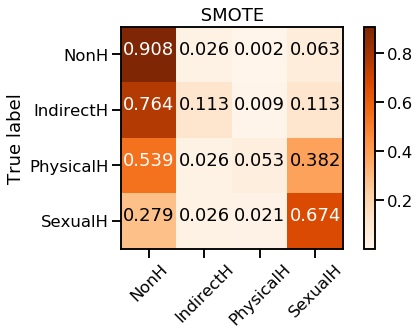

Test_ acc: 0.8002826189354687
Test_ f1 none: [0.889 0.14  0.087 0.644]
Test_ f1 macro: 0.440055901414774


Ejemplo de tweet con label  NonH  y tweet_id  1618
Encoder Layer 1


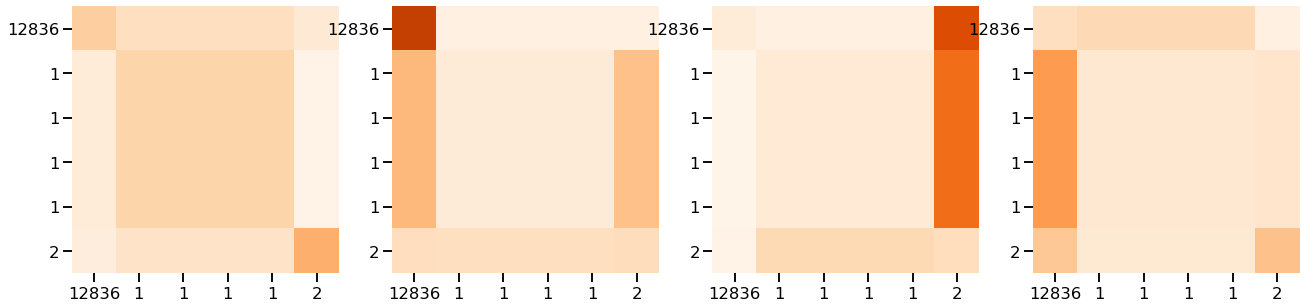

Encoder Layer 2


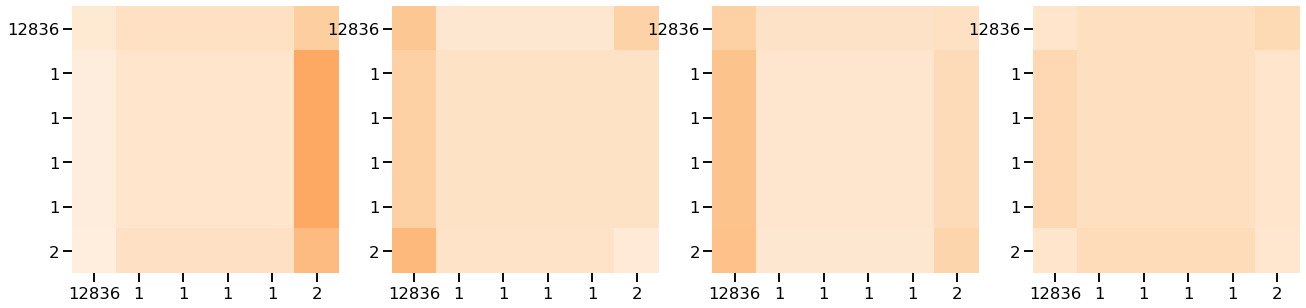



Ejemplo de tweet con label  IndirectH  y tweet_id  312
Encoder Layer 1


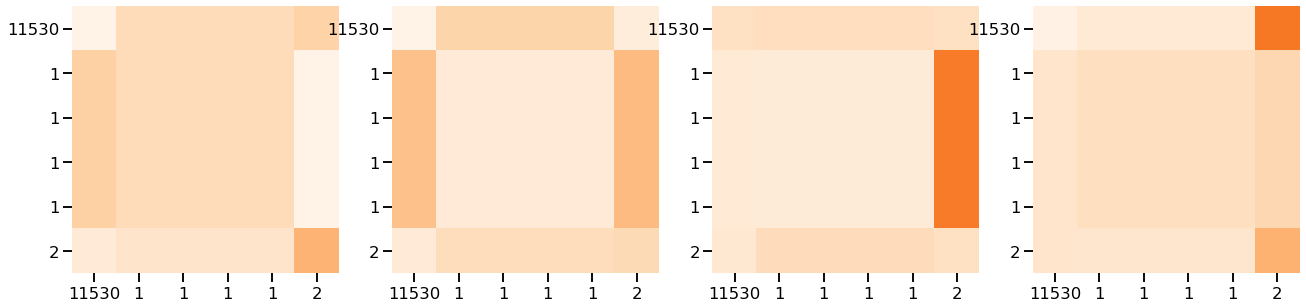

Encoder Layer 2


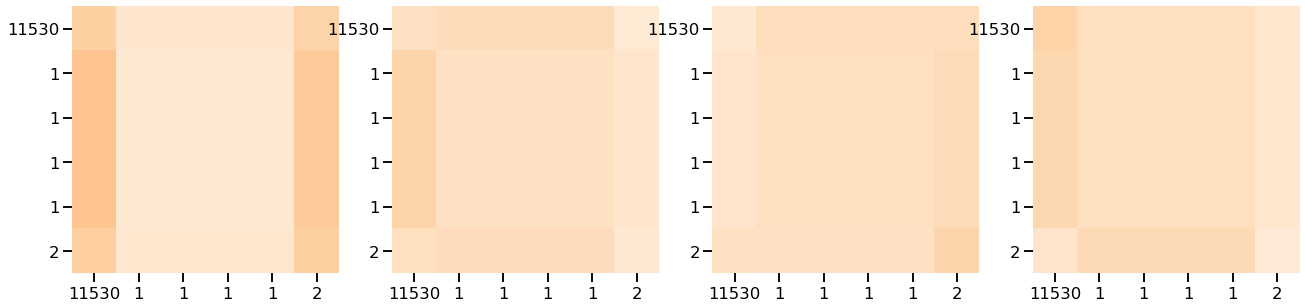



Ejemplo de tweet con label  PhysicalH  y tweet_id  2079
Encoder Layer 1


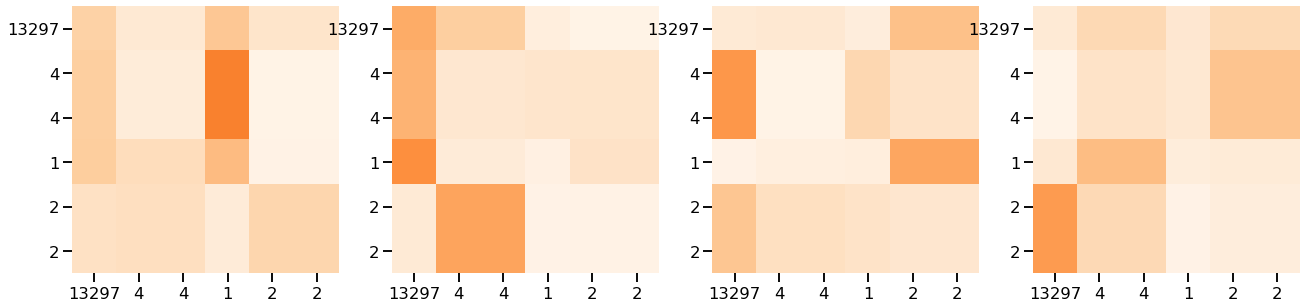

Encoder Layer 2


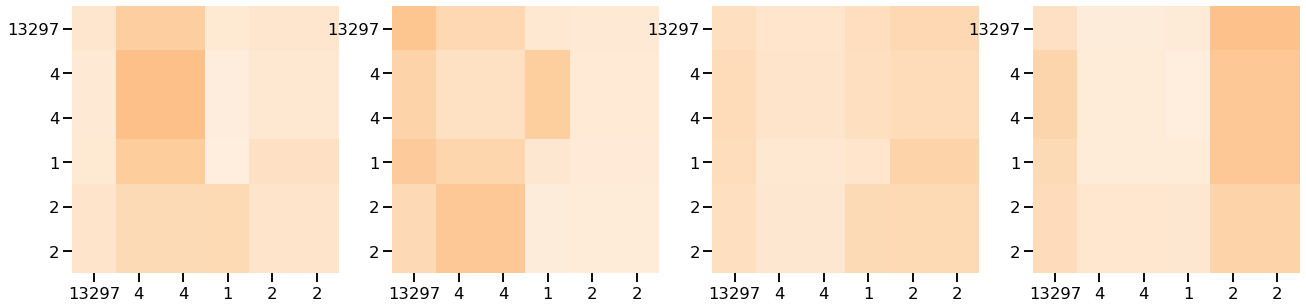



Ejemplo de tweet con label  SexualH  y tweet_id  2069
Encoder Layer 1


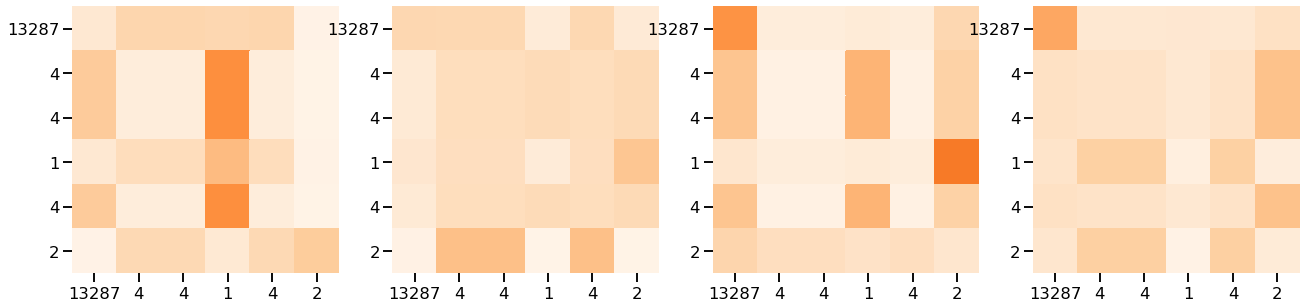

Encoder Layer 2


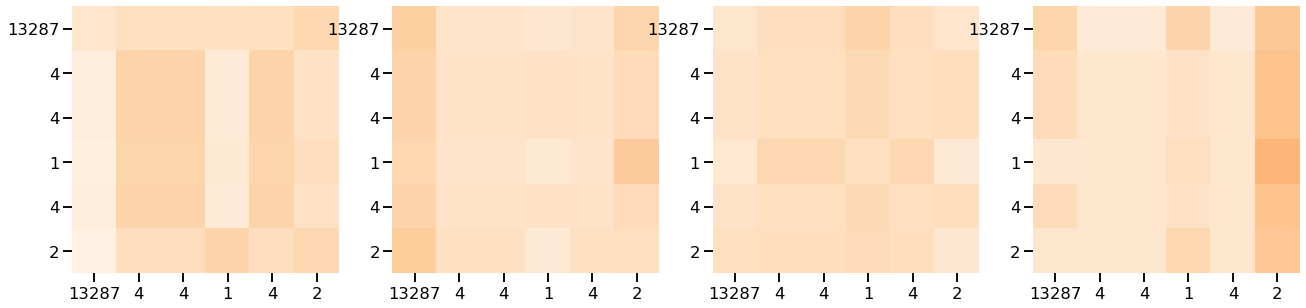

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 2  ------------------- 



Accuracy sobre Test cnn1 : 0.8078191238813001
F1-score None sobre Test cnn1 : [0.891 0.11  0.112 0.683]
F1-score macro sobre Test cnn1 : 0.4491549003188568

Accuracy sobre Test cnn2 : 0.8134715025906736
F1-score None sobre Test cnn2 : [0.895 0.146 0.101 0.703]
F1-score macro sobre Test cnn2 : 0.46147454917040054

Accuracy sobre Test rnn1 : 0.16674517192651908
F1-score None sobre Test rnn1 : [0.148 0.086 0.    0.306]
F1-score macro sobre Test rnn1 : 0.13485980379884144

Accuracy sobre Test rnn2 : 0.09326424870466321
F1-score None sobre Test rnn2 : [0.01  0.092 0.    0.334]
F1-score macro sobre Test rnn2 : 0.10920905776343157

Accuracy sobre Test rnn3 : 0.29627885068299575
F1-score None sobre Test rnn3 : [0.359 0.064 0.099 0.317]
F1-score macro sobre Test rnn3 : 0.20974516605677024

--------------------------------------------------------
Trabajando en predicciones Test - Máq

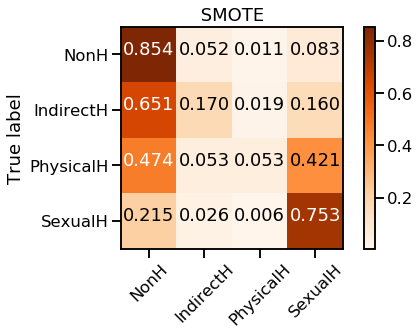

Test_ acc: 0.7748469147432878
Test_ f1 none: [0.869 0.164 0.078 0.658]
Test_ f1 macro: 0.4423013683547343


Ejemplo de tweet con label  NonH  y tweet_id  836
Encoder Layer 1


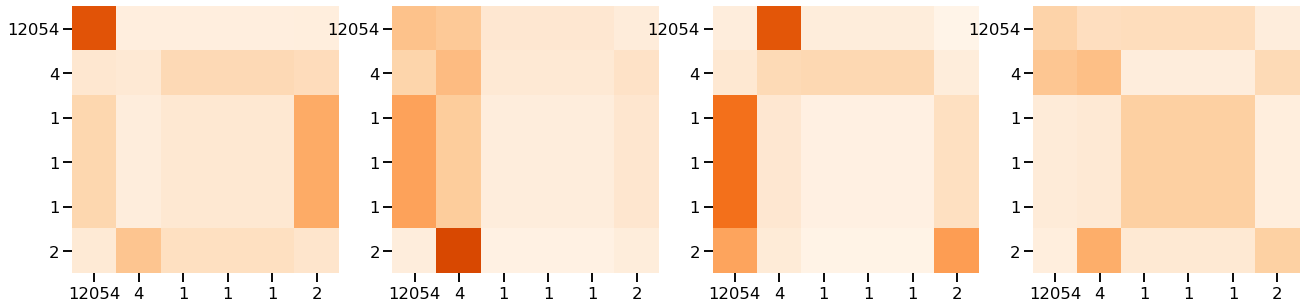

Encoder Layer 2


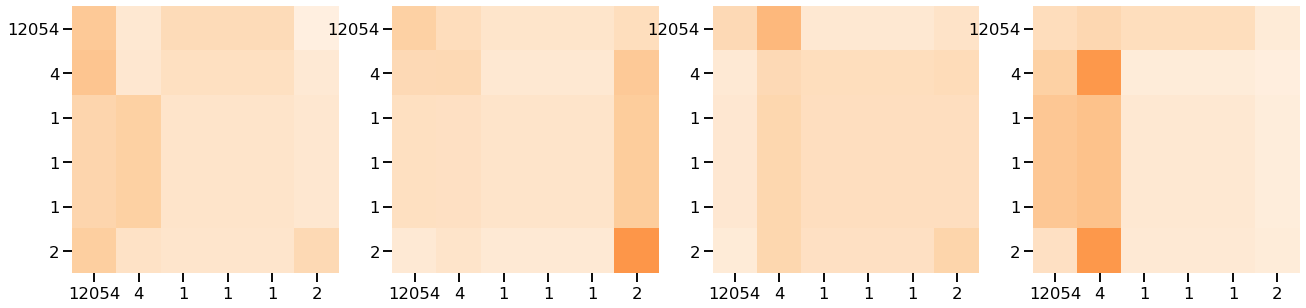



Ejemplo de tweet con label  IndirectH  y tweet_id  1089
Encoder Layer 1


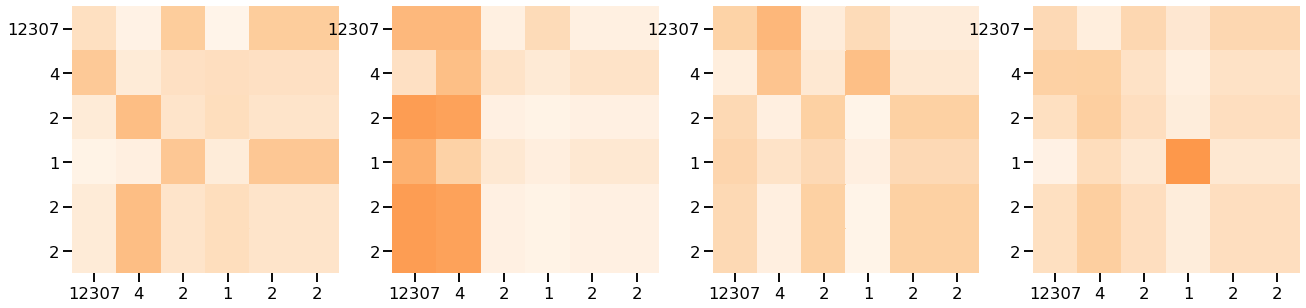

Encoder Layer 2


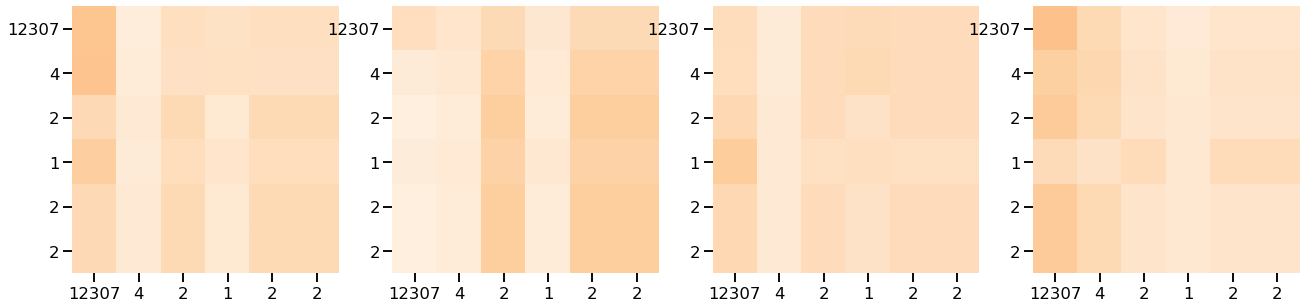



Ejemplo de tweet con label  PhysicalH  y tweet_id  548
Encoder Layer 1


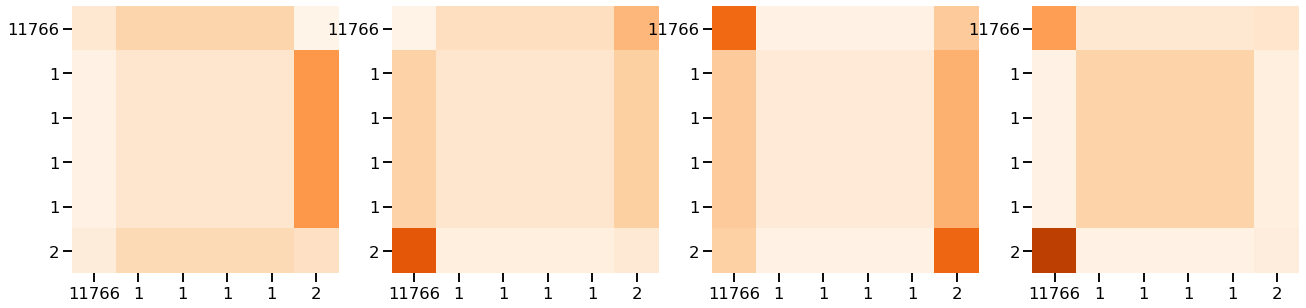

Encoder Layer 2


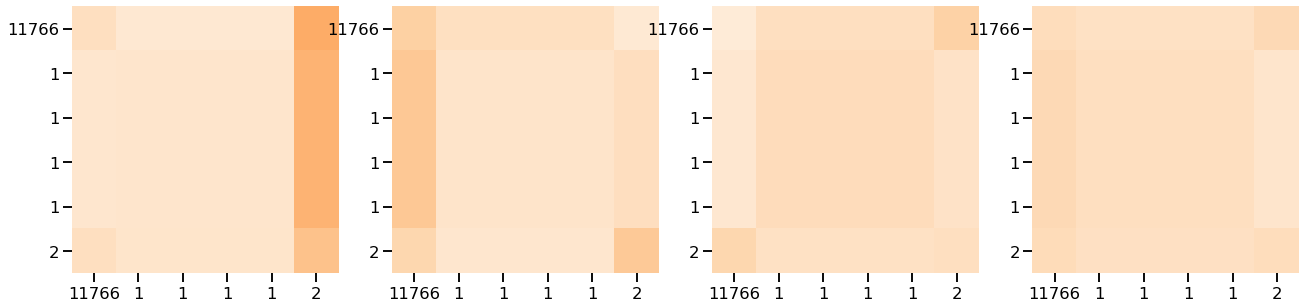



Ejemplo de tweet con label  SexualH  y tweet_id  82
Encoder Layer 1


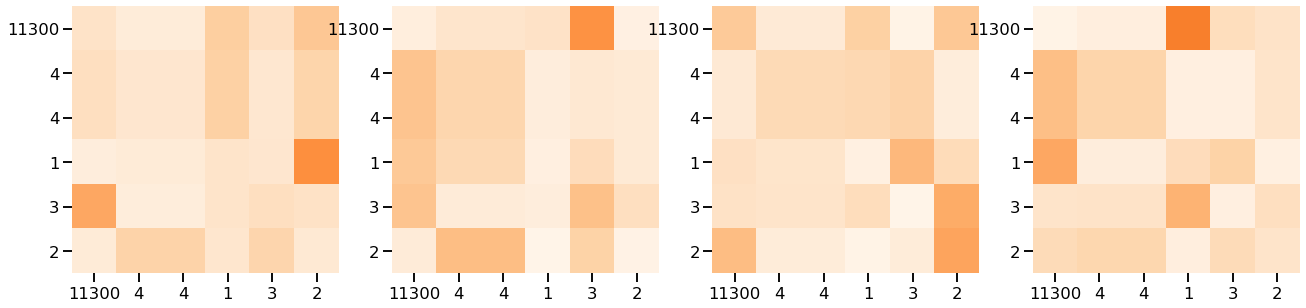

Encoder Layer 2


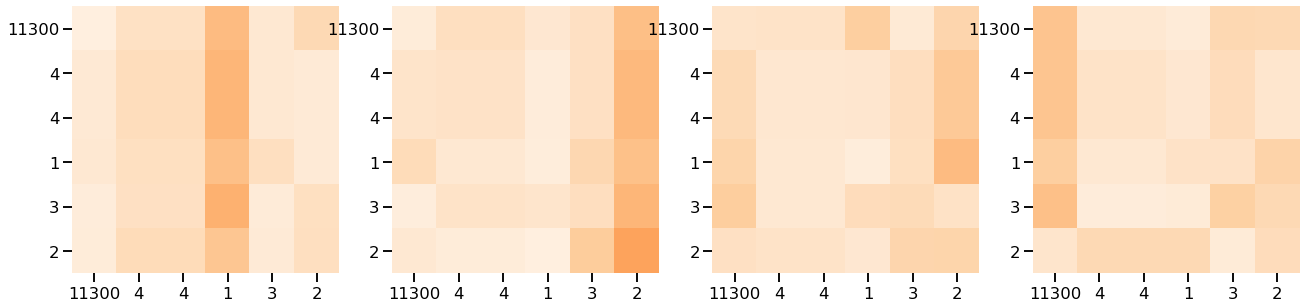

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 3  ------------------- 



Accuracy sobre Test cnn1 : 0.7574187470560527
F1-score None sobre Test cnn1 : [0.861 0.171 0.145 0.673]
F1-score macro sobre Test cnn1 : 0.46232490159380635

Accuracy sobre Test cnn2 : 0.8200659444182761
F1-score None sobre Test cnn2 : [0.899 0.121 0.168 0.695]
F1-score macro sobre Test cnn2 : 0.47100767864599824

Accuracy sobre Test rnn1 : 0.7362223268959021
F1-score None sobre Test rnn1 : [0.851 0.094 0.16  0.338]
F1-score macro sobre Test rnn1 : 0.3608336592477469

Accuracy sobre Test rnn2 : 0.039566650965614694
F1-score None sobre Test rnn2 : [0.01  0.    0.069 0.   ]
F1-score macro sobre Test rnn2 : 0.019829694844636758

Accuracy sobre Test rnn3 : 0.7541215261422516
F1-score None sobre Test rnn3 : [0.86 0.   0.   0.  ]
F1-score macro sobre Test rnn3 : 0.21495703544575726

--------------------------------------------------------
Trabajando en predicciones Test - Máquina

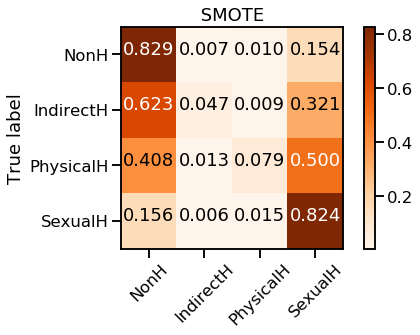

Test_ acc: 0.7621290626471974
Test_ f1 none: [0.862 0.08  0.115 0.596]
Test_ f1 macro: 0.41350298881014647
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 4  ------------------- 



Accuracy sobre Test cnn1 : 0.8111163447951013
F1-score None sobre Test cnn1 : [0.896 0.131 0.136 0.667]
F1-score macro sobre Test cnn1 : 0.4571275605550499

Accuracy sobre Test cnn2 : 0.7819123881300047
F1-score None sobre Test cnn2 : [0.871 0.131 0.129 0.672]
F1-score macro sobre Test cnn2 : 0.4507331538316742

Accuracy sobre Test rnn1 : 0.7475270843146491
F1-score None sobre Test rnn1 : [0.86  0.089 0.164 0.316]
F1-score macro sobre Test rnn1 : 0.35714101291839584

Accuracy sobre Test rnn2 : 0.29674988224211024
F1-score None sobre Test rnn2 : [0.356 0.091 0.    0.368]
F1-score macro sobre Test rnn2 : 0.20356583829769948

Accuracy sobre Test rnn3 : 0.37447008949599625
F1-score None sobre Test rnn3 : [0.531 0.129 0.132 0.276]
F1-score macro sobre Test rnn3 : 0.26730192

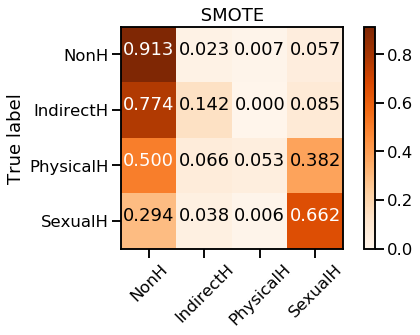

Test_ acc: 0.80357983984927
Test_ f1 none: [0.891 0.17  0.086 0.648]
Test_ f1 macro: 0.4488849583134583


Ejemplo de tweet con label  NonH  y tweet_id  861
Encoder Layer 1


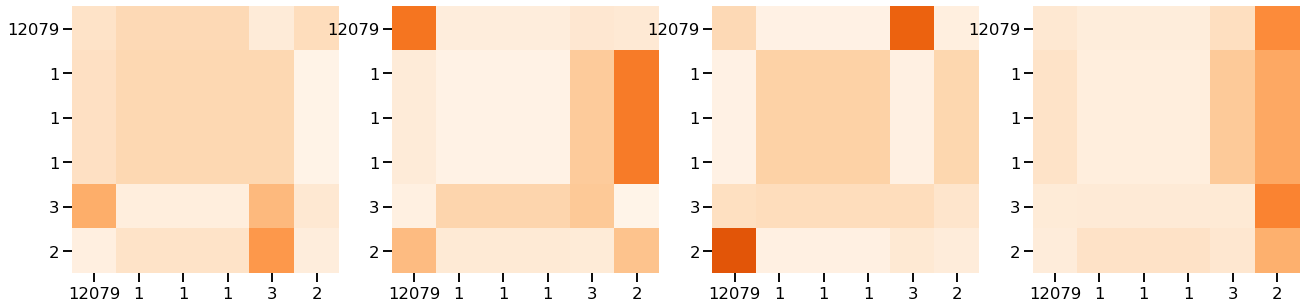

Encoder Layer 2


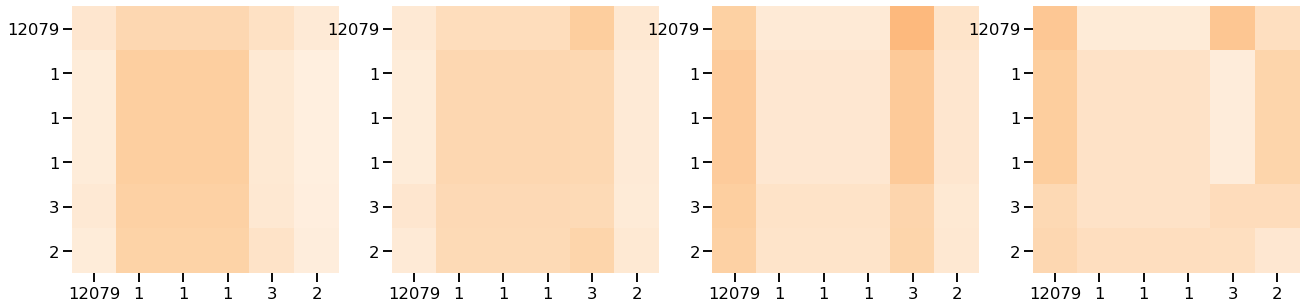



Ejemplo de tweet con label  IndirectH  y tweet_id  1737
Encoder Layer 1


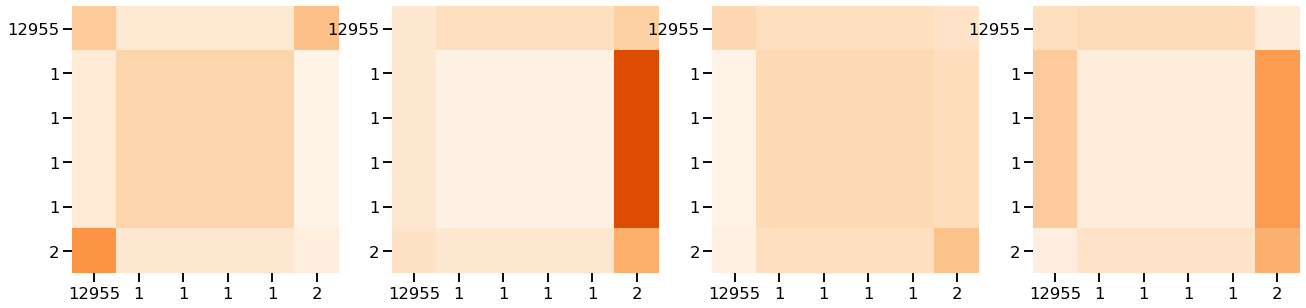

Encoder Layer 2


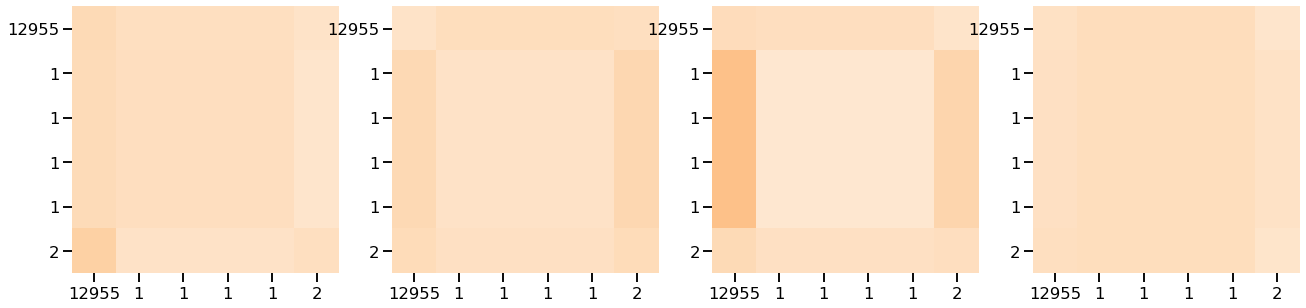



Ejemplo de tweet con label  PhysicalH  y tweet_id  1675
Encoder Layer 1


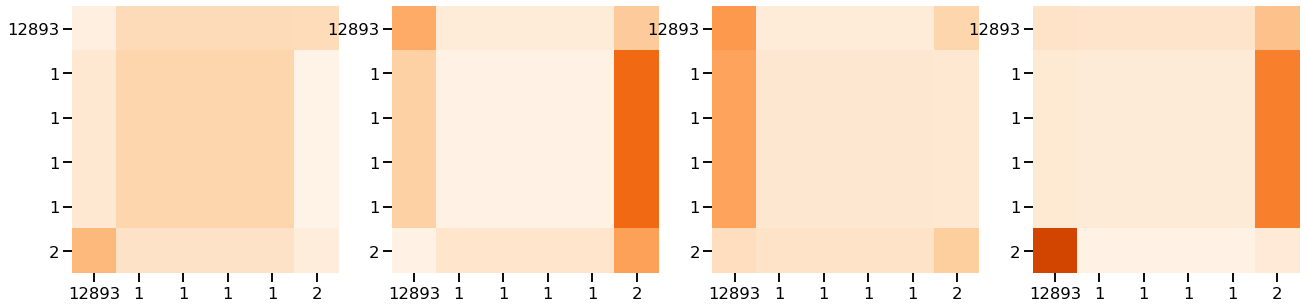

Encoder Layer 2


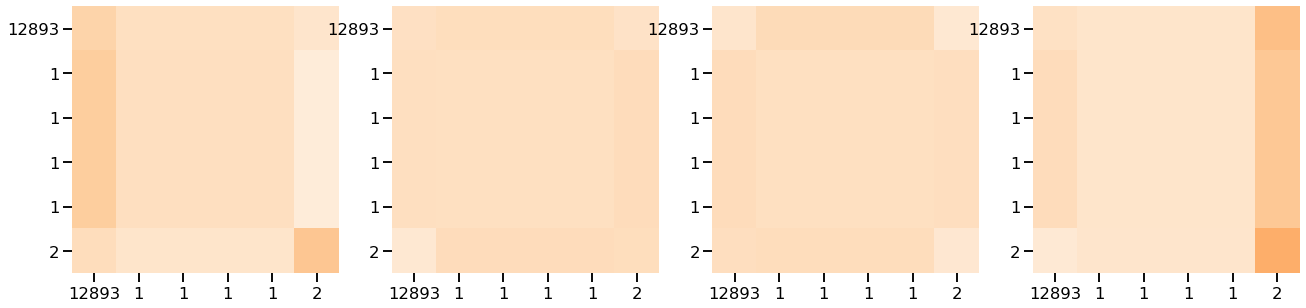



Ejemplo de tweet con label  SexualH  y tweet_id  764
Encoder Layer 1


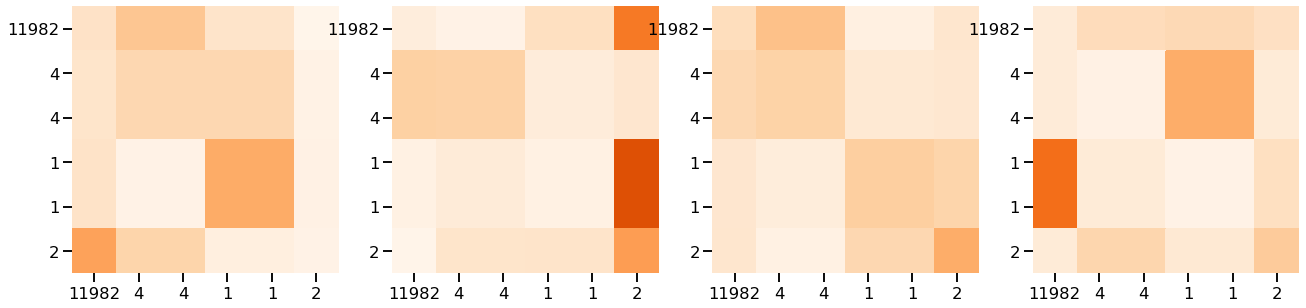

Encoder Layer 2


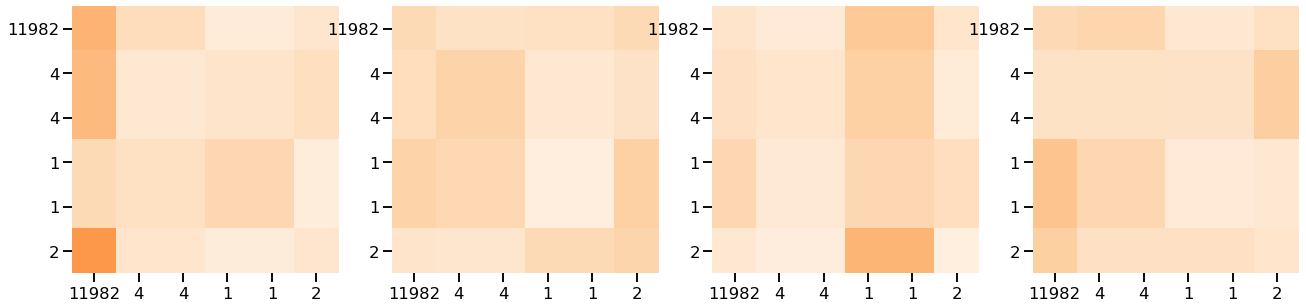

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 5  ------------------- 



Accuracy sobre Test cnn1 : 0.7922750824305228
F1-score None sobre Test cnn1 : [0.883 0.146 0.081 0.593]
F1-score macro sobre Test cnn1 : 0.425600649559773

Accuracy sobre Test cnn2 : 0.7715496938294866
F1-score None sobre Test cnn2 : [0.871 0.132 0.165 0.675]
F1-score macro sobre Test cnn2 : 0.4609699303803747

Accuracy sobre Test rnn1 : 0.6057465850211964
F1-score None sobre Test rnn1 : [0.76  0.16  0.147 0.429]
F1-score macro sobre Test rnn1 : 0.37395407696378974

Accuracy sobre Test rnn2 : 0.36834667922750824
F1-score None sobre Test rnn2 : [0.447 0.081 0.    0.347]
F1-score macro sobre Test rnn2 : 0.21879666844686907

Accuracy sobre Test rnn3 : 0.039566650965614694
F1-score None sobre Test rnn3 : [0.01  0.    0.069 0.   ]
F1-score macro sobre Test rnn3 : 0.019829694844636758

--------------------------------------------------------
Trabajando en predicciones Test - Máqu

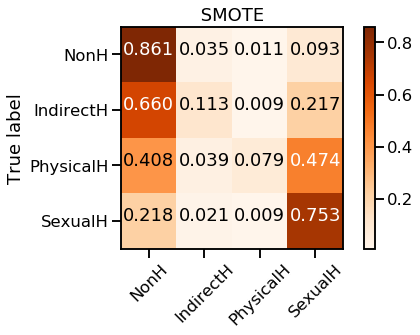

Test_ acc: 0.7781441356570891
Test_ f1 none: [0.874 0.13  0.115 0.637]
Test_ f1 macro: 0.43911158799985944
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 6  ------------------- 



Accuracy sobre Test cnn1 : 0.7974564295807819
F1-score None sobre Test cnn1 : [0.885 0.052 0.13  0.655]
F1-score macro sobre Test cnn1 : 0.4305264869249903

Accuracy sobre Test cnn2 : 0.8064060292039567
F1-score None sobre Test cnn2 : [0.893 0.142 0.046 0.699]
F1-score macro sobre Test cnn2 : 0.4452070463987871

Accuracy sobre Test rnn1 : 0.7644842204427696
F1-score None sobre Test rnn1 : [0.863 0.    0.    0.453]
F1-score macro sobre Test rnn1 : 0.32893100107879614

Accuracy sobre Test rnn2 : 0.07583608101742817
F1-score None sobre Test rnn2 : [0.01  0.094 0.    0.241]
F1-score macro sobre Test rnn2 : 0.08628707483640134

Accuracy sobre Test rnn3 : 0.7051342439943477
F1-score None sobre Test rnn3 : [0.826 0.    0.    0.246]
F1-score macro sobre Test rnn3 : 0.268017013

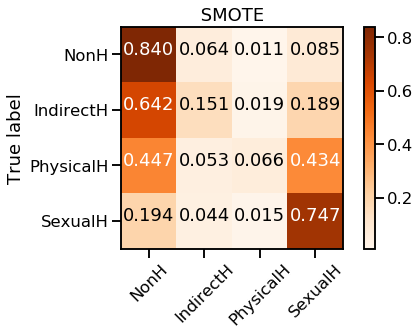

Test_ acc: 0.7630711257654262
Test_ f1 none: [0.864 0.131 0.095 0.649]
Test_ f1 macro: 0.4347532683264964
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 7  ------------------- 



Accuracy sobre Test cnn1 : 0.8049929345266132
F1-score None sobre Test cnn1 : [0.893 0.131 0.138 0.669]
F1-score macro sobre Test cnn1 : 0.457813481128606

Accuracy sobre Test cnn2 : 0.802637776731041
F1-score None sobre Test cnn2 : [0.889 0.137 0.114 0.652]
F1-score macro sobre Test cnn2 : 0.4480545427964391

Accuracy sobre Test rnn1 : 0.7578897786151673
F1-score None sobre Test rnn1 : [0.86  0.    0.    0.157]
F1-score macro sobre Test rnn1 : 0.2542450128327991

Accuracy sobre Test rnn2 : 0.05605275553462082
F1-score None sobre Test rnn2 : [0.01  0.094 0.    0.04 ]
F1-score macro sobre Test rnn2 : 0.036004785946531545

Accuracy sobre Test rnn3 : 0.7541215261422516
F1-score None sobre Test rnn3 : [0.86 0.   0.   0.  ]
F1-score macro sobre Test rnn3 : 0.2149570354457572

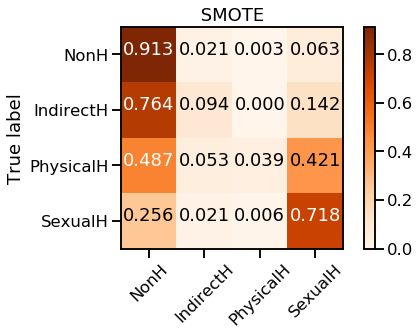

Test_ acc: 0.8097032501177579
Test_ f1 none: [0.895 0.125 0.07  0.667]
Test_ f1 macro: 0.43904273765809876
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 8  ------------------- 



Accuracy sobre Test cnn1 : 0.8068770607630711
F1-score None sobre Test cnn1 : [0.892 0.164 0.088 0.683]
F1-score macro sobre Test cnn1 : 0.45669033788571567

Accuracy sobre Test cnn2 : 0.8021667451719265
F1-score None sobre Test cnn2 : [0.888 0.149 0.047 0.681]
F1-score macro sobre Test cnn2 : 0.44122387775301564

Accuracy sobre Test rnn1 : 0.6000942063118229
F1-score None sobre Test rnn1 : [0.751 0.152 0.153 0.438]
F1-score macro sobre Test rnn1 : 0.37368759575471944

Accuracy sobre Test rnn2 : 0.5661799340555818
F1-score None sobre Test rnn2 : [0.721 0.151 0.137 0.417]
F1-score macro sobre Test rnn2 : 0.35641638363214023

Accuracy sobre Test rnn3 : 0.3758831841733396
F1-score None sobre Test rnn3 : [0.452 0.    0.    0.323]
F1-score macro sobre Test rnn3 : 0.19386532

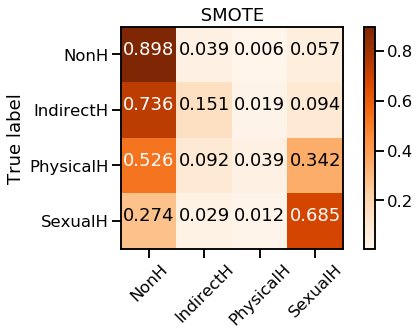

Test_ acc: 0.795572303344324
Test_ f1 none: [0.885 0.158 0.063 0.666]
Test_ f1 macro: 0.44296697319118533
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 9  ------------------- 



Accuracy sobre Test cnn1 : 0.7908619877531795
F1-score None sobre Test cnn1 : [0.882 0.126 0.093 0.667]
F1-score macro sobre Test cnn1 : 0.4420142633144891

Accuracy sobre Test cnn2 : 0.7960433349034385
F1-score None sobre Test cnn2 : [0.884 0.143 0.072 0.672]
F1-score macro sobre Test cnn2 : 0.4428211987570132

Accuracy sobre Test rnn1 : 0.0574658502119642
F1-score None sobre Test rnn1 : [0.01  0.097 0.    0.051]
F1-score macro sobre Test rnn1 : 0.03943859414115183

Accuracy sobre Test rnn2 : 0.7131417804992934
F1-score None sobre Test rnn2 : [0.83  0.102 0.11  0.452]
F1-score macro sobre Test rnn2 : 0.373364428193121

Accuracy sobre Test rnn3 : 0.7098445595854922
F1-score None sobre Test rnn3 : [0.845 0.042 0.    0.087]
F1-score macro sobre Test rnn3 : 0.2434308449515

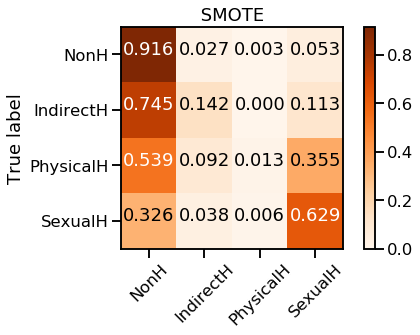

Test_ acc: 0.7993405558172397
Test_ f1 none: [0.889 0.162 0.024 0.631]
Test_ f1 macro: 0.42665013369899807
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 10  ------------------- 



Accuracy sobre Test cnn1 : 0.7993405558172397
F1-score None sobre Test cnn1 : [0.889 0.13  0.105 0.679]
F1-score macro sobre Test cnn1 : 0.4507413933291663

Accuracy sobre Test cnn2 : 0.7993405558172397
F1-score None sobre Test cnn2 : [0.886 0.132 0.169 0.689]
F1-score macro sobre Test cnn2 : 0.46915442504682575

Accuracy sobre Test rnn1 : 0.37776731040979744
F1-score None sobre Test rnn1 : [0.524 0.126 0.097 0.407]
F1-score macro sobre Test rnn1 : 0.28842737870515905

Accuracy sobre Test rnn2 : 0.7103155911446067
F1-score None sobre Test rnn2 : [0.837 0.087 0.199 0.433]
F1-score macro sobre Test rnn2 : 0.3886622308454026

Accuracy sobre Test rnn3 : 0.16391898257183232
F1-score None sobre Test rnn3 : [0.01  0.    0.    0.277]
F1-score macro sobre Test rnn3 : 0.0717324

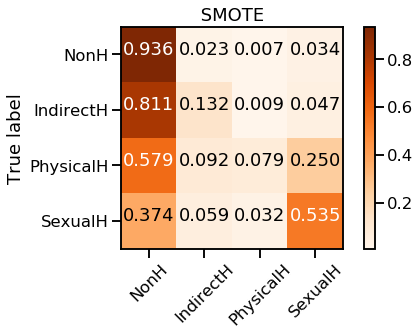

Test_ acc: 0.8007536504945831
Test_ f1 none: [0.893 0.152 0.113 0.607]
Test_ f1 macro: 0.4411943916723132
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 11  ------------------- 



Accuracy sobre Test cnn1 : 0.7804992934526613
F1-score None sobre Test cnn1 : [0.871 0.144 0.096 0.664]
F1-score macro sobre Test cnn1 : 0.44413454585544293

Accuracy sobre Test cnn2 : 0.8115873763542157
F1-score None sobre Test cnn2 : [0.896 0.082 0.14  0.686]
F1-score macro sobre Test cnn2 : 0.45091340000442287

Accuracy sobre Test rnn1 : 0.28450306170513423
F1-score None sobre Test rnn1 : [0.391 0.133 0.086 0.341]
F1-score macro sobre Test rnn1 : 0.23785481712710924

Accuracy sobre Test rnn2 : 0.30004710315591143
F1-score None sobre Test rnn2 : [0.383 0.069 0.105 0.336]
F1-score macro sobre Test rnn2 : 0.22312382963277694

Accuracy sobre Test rnn3 : 0.16391898257183232
F1-score None sobre Test rnn3 : [0.01  0.    0.    0.277]
F1-score macro sobre Test rnn3 : 0.07173

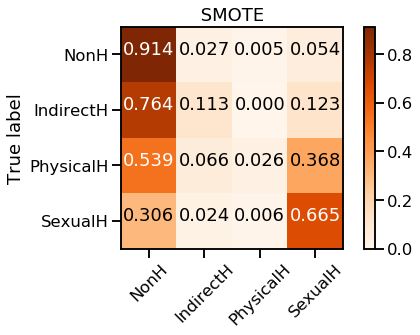

Test_ acc: 0.8021667451719265
Test_ f1 none: [0.889 0.137 0.045 0.652]
Test_ f1 macro: 0.43104893924042864
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 12  ------------------- 



Accuracy sobre Test cnn1 : 0.8031088082901554
F1-score None sobre Test cnn1 : [0.89  0.093 0.192 0.684]
F1-score macro sobre Test cnn1 : 0.4649375662690722

Accuracy sobre Test cnn2 : 0.8106453132359868
F1-score None sobre Test cnn2 : [0.895 0.119 0.218 0.699]
F1-score macro sobre Test cnn2 : 0.4828176742956617

Accuracy sobre Test rnn1 : 0.6919453603391427
F1-score None sobre Test rnn1 : [0.829 0.138 0.175 0.391]
F1-score macro sobre Test rnn1 : 0.38348513265946754

Accuracy sobre Test rnn2 : 0.41356570890249644
F1-score None sobre Test rnn2 : [0.579 0.106 0.079 0.355]
F1-score macro sobre Test rnn2 : 0.2799902909683586

Accuracy sobre Test rnn3 : 0.7541215261422516
F1-score None sobre Test rnn3 : [0.86 0.   0.   0.  ]
F1-score macro sobre Test rnn3 : 0.2149570354457

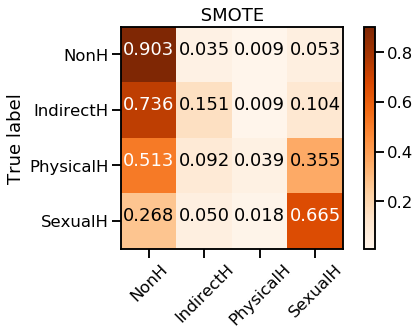

Test_ acc: 0.7960433349034385
Test_ f1 none: [0.888 0.158 0.059 0.656]
Test_ f1 macro: 0.4404956702361923
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 13  ------------------- 



Accuracy sobre Test cnn1 : 0.7880357983984927
F1-score None sobre Test cnn1 : [0.88  0.148 0.13  0.68 ]
F1-score macro sobre Test cnn1 : 0.4595382556856138

Accuracy sobre Test cnn2 : 0.8064060292039567
F1-score None sobre Test cnn2 : [0.893 0.112 0.143 0.678]
F1-score macro sobre Test cnn2 : 0.45647938702994884

Accuracy sobre Test rnn1 : 0.5774846914743288
F1-score None sobre Test rnn1 : [0.735 0.146 0.151 0.406]
F1-score macro sobre Test rnn1 : 0.3595483176213896

Accuracy sobre Test rnn2 : 0.3674046161092793
F1-score None sobre Test rnn2 : [0.465 0.099 0.    0.351]
F1-score macro sobre Test rnn2 : 0.22888665712304723

Accuracy sobre Test rnn3 : 0.053697597739048517
F1-score None sobre Test rnn3 : [0.01  0.095 0.    0.   ]
F1-score macro sobre Test rnn3 : 0.02634914

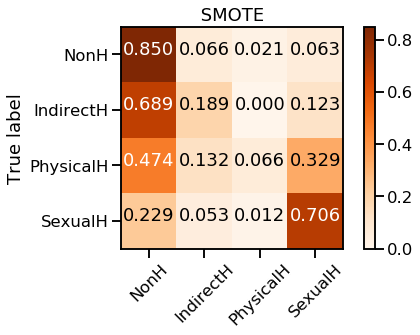

Test_ acc: 0.765897315120113
Test_ f1 none: [0.864 0.154 0.085 0.668]
Test_ f1 macro: 0.4426467985541056
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 14  ------------------- 



Accuracy sobre Test cnn1 : 0.8125294394724446
F1-score None sobre Test cnn1 : [0.897 0.089 0.097 0.665]
F1-score macro sobre Test cnn1 : 0.4370891880417359

Accuracy sobre Test cnn2 : 0.7946302402260952
F1-score None sobre Test cnn2 : [0.883 0.142 0.13  0.636]
F1-score macro sobre Test cnn2 : 0.4480229217059193

Accuracy sobre Test rnn1 : 0.5977390485162506
F1-score None sobre Test rnn1 : [0.749 0.148 0.143 0.421]
F1-score macro sobre Test rnn1 : 0.3652556161761692

Accuracy sobre Test rnn2 : 0.6914743287800282
F1-score None sobre Test rnn2 : [0.811 0.092 0.121 0.473]
F1-score macro sobre Test rnn2 : 0.37406808117898543

Accuracy sobre Test rnn3 : 0.10645313235986811
F1-score None sobre Test rnn3 : [0.137 0.    0.073 0.158]
F1-score macro sobre Test rnn3 : 0.09222908378

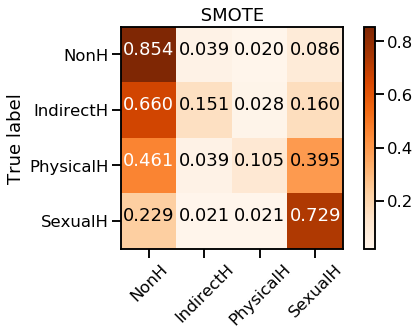

Test_ acc: 0.7724917569477155
Test_ f1 none: [0.868 0.164 0.127 0.642]
Test_ f1 macro: 0.4501907204532615


Ejemplo de tweet con label  NonH  y tweet_id  1499
Encoder Layer 1


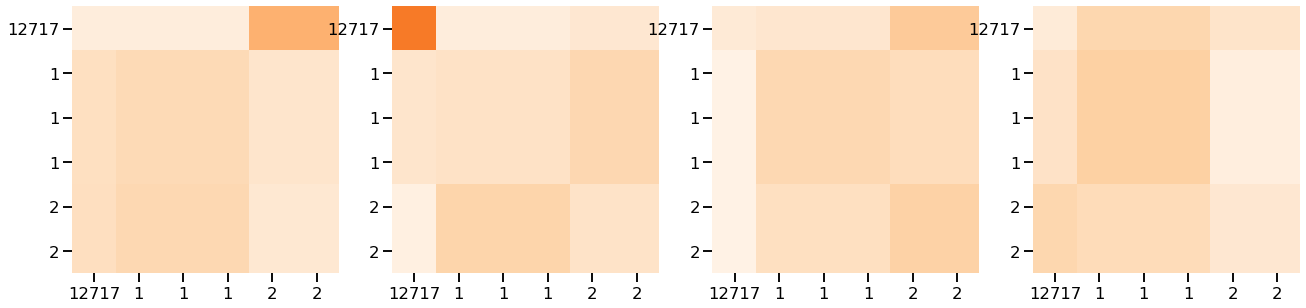

Encoder Layer 2


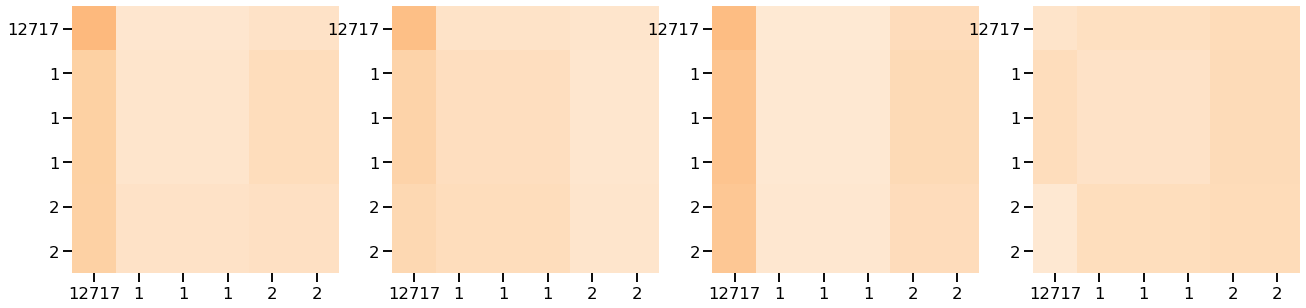



Ejemplo de tweet con label  IndirectH  y tweet_id  1487
Encoder Layer 1


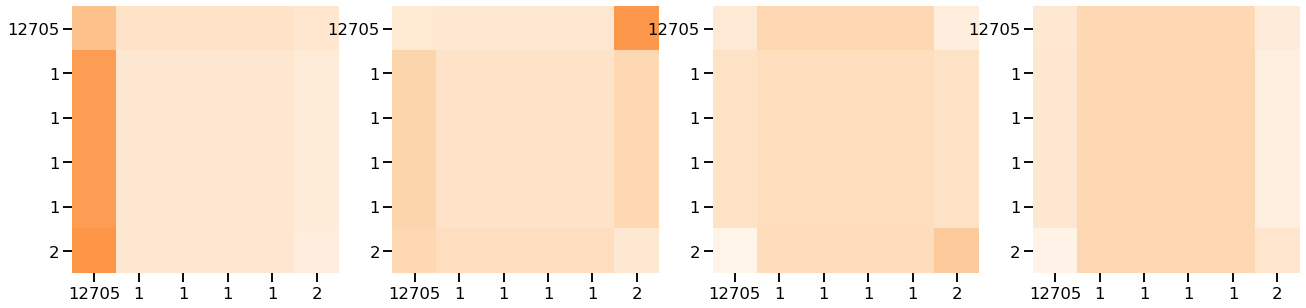

Encoder Layer 2


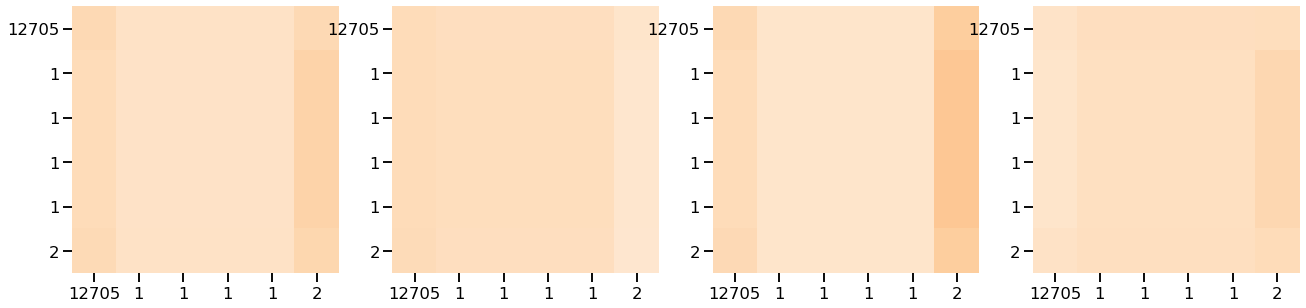



Ejemplo de tweet con label  PhysicalH  y tweet_id  784
Encoder Layer 1


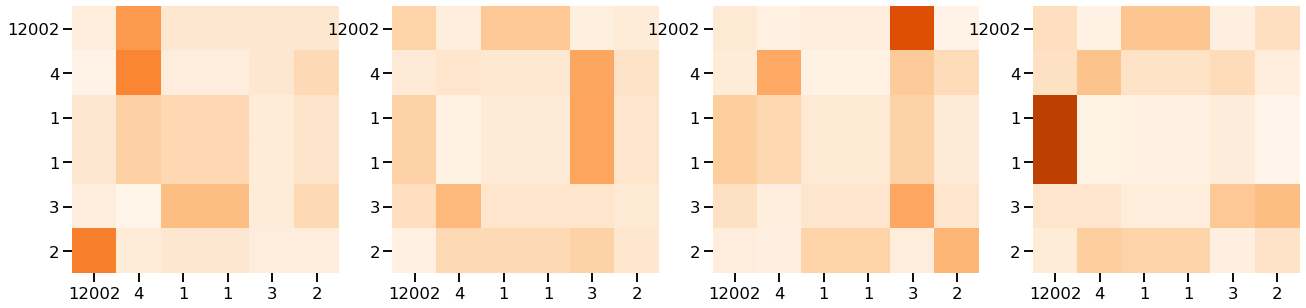

Encoder Layer 2


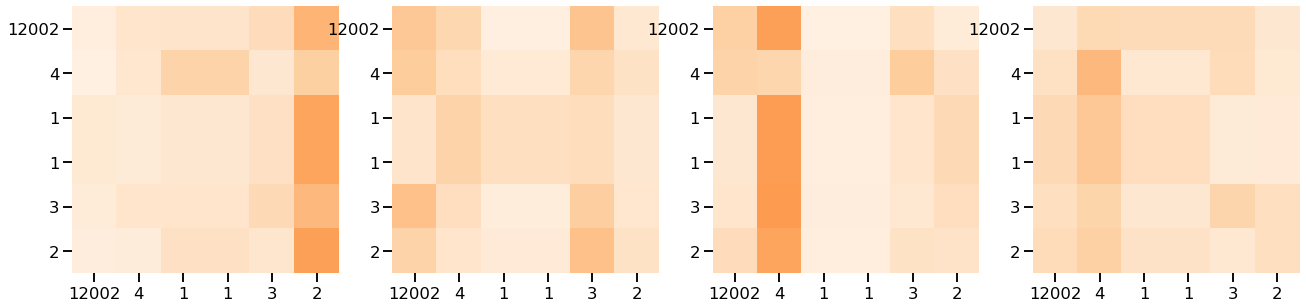



Ejemplo de tweet con label  SexualH  y tweet_id  1305
Encoder Layer 1


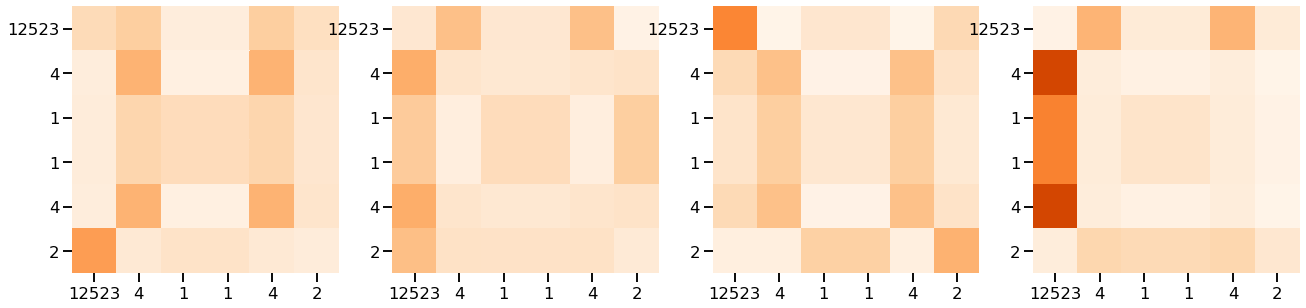

Encoder Layer 2


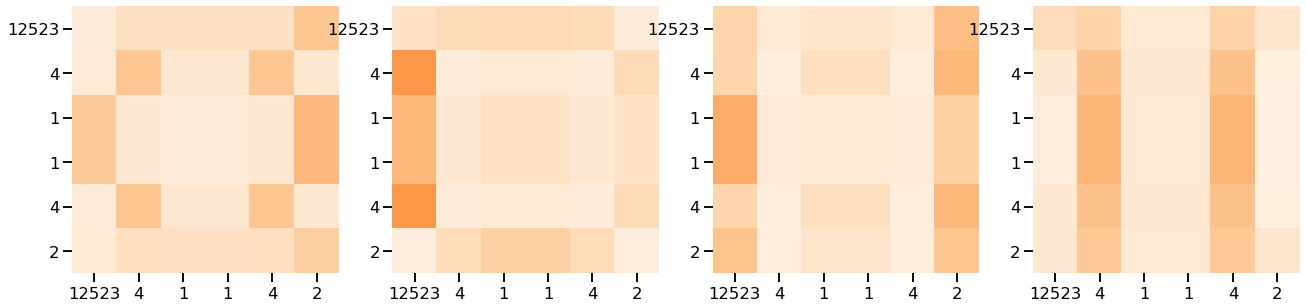

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 15  ------------------- 



Accuracy sobre Test cnn1 : 0.8012246820536976
F1-score None sobre Test cnn1 : [0.887 0.124 0.163 0.674]
F1-score macro sobre Test cnn1 : 0.4619003283686792

Accuracy sobre Test cnn2 : 0.7706076307112577
F1-score None sobre Test cnn2 : [0.873 0.129 0.154 0.642]
F1-score macro sobre Test cnn2 : 0.4495159871086782

Accuracy sobre Test rnn1 : 0.31700423928403204
F1-score None sobre Test rnn1 : [0.432 0.133 0.099 0.393]
F1-score macro sobre Test rnn1 : 0.26411754937605636

Accuracy sobre Test rnn2 : 0.5506358926048045
F1-score None sobre Test rnn2 : [0.697 0.082 0.126 0.366]
F1-score macro sobre Test rnn2 : 0.3176143727917705

Accuracy sobre Test rnn3 : 0.06924163918982572
F1-score None sobre Test rnn3 : [0.056 0.094 0.    0.   ]
F1-score macro sobre Test rnn3 : 0.03731297670542927

--------------------------------------------------------
Trabajando en predicciones Test - Máqui

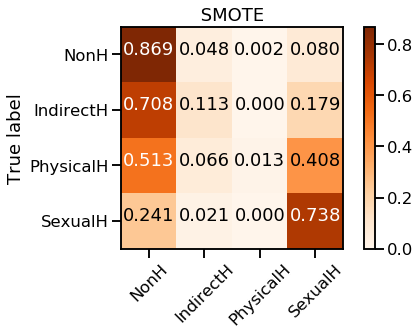

Test_ acc: 0.7800282618935469
Test_ f1 none: [0.873 0.116 0.025 0.653]
Test_ f1 macro: 0.416607541623899
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 16  ------------------- 



Accuracy sobre Test cnn1 : 0.7913330193122939
F1-score None sobre Test cnn1 : [0.883 0.085 0.103 0.654]
F1-score macro sobre Test cnn1 : 0.43105103994492916

Accuracy sobre Test cnn2 : 0.8195949128591615
F1-score None sobre Test cnn2 : [0.895 0.103 0.047 0.687]
F1-score macro sobre Test cnn2 : 0.4330132016473479

Accuracy sobre Test rnn1 : 0.4837494112105511
F1-score None sobre Test rnn1 : [0.645 0.131 0.135 0.458]
F1-score macro sobre Test rnn1 : 0.34208901993185087

Accuracy sobre Test rnn2 : 0.6019783325482807
F1-score None sobre Test rnn2 : [0.758 0.092 0.154 0.398]
F1-score macro sobre Test rnn2 : 0.3505625189727788

Accuracy sobre Test rnn3 : 0.21008007536504947
F1-score None sobre Test rnn3 : [0.296 0.098 0.    0.275]
F1-score macro sobre Test rnn3 : 0.1671336407

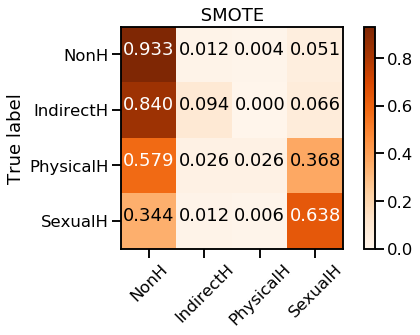

Test_ acc: 0.8115873763542157
Test_ f1 none: [0.893 0.142 0.047 0.644]
Test_ f1 macro: 0.43138651402141676
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 17  ------------------- 



Accuracy sobre Test cnn1 : 0.8064060292039567
F1-score None sobre Test cnn1 : [0.891 0.104 0.108 0.669]
F1-score macro sobre Test cnn1 : 0.4429902198126964

Accuracy sobre Test cnn2 : 0.8125294394724446
F1-score None sobre Test cnn2 : [0.895 0.093 0.208 0.688]
F1-score macro sobre Test cnn2 : 0.4708794797571383

Accuracy sobre Test rnn1 : 0.7418747056052756
F1-score None sobre Test rnn1 : [0.85  0.117 0.088 0.411]
F1-score macro sobre Test rnn1 : 0.3666727932613603

Accuracy sobre Test rnn2 : 0.13094677343382008
F1-score None sobre Test rnn2 : [0.01  0.109 0.    0.349]
F1-score macro sobre Test rnn2 : 0.11685286381559883

Accuracy sobre Test rnn3 : 0.6900612341026848
F1-score None sobre Test rnn3 : [0.821 0.099 0.137 0.178]
F1-score macro sobre Test rnn3 : 0.308751528

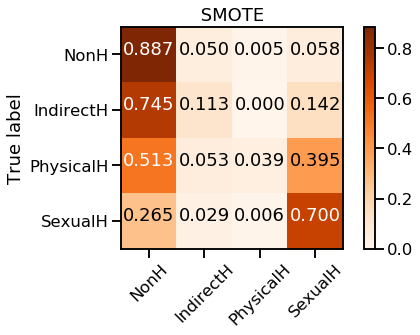

Test_ acc: 0.7880357983984927
Test_ f1 none: [0.88  0.113 0.067 0.665]
Test_ f1 macro: 0.43123925320181666
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 18  ------------------- 



Accuracy sobre Test cnn1 : 0.7951012717852096
F1-score None sobre Test cnn1 : [0.886 0.184 0.182 0.674]
F1-score macro sobre Test cnn1 : 0.48151123741591295

Accuracy sobre Test cnn2 : 0.8002826189354687
F1-score None sobre Test cnn2 : [0.888 0.118 0.065 0.662]
F1-score macro sobre Test cnn2 : 0.433471876604565

Accuracy sobre Test rnn1 : 0.371172868582195
F1-score None sobre Test rnn1 : [0.508 0.135 0.116 0.399]
F1-score macro sobre Test rnn1 : 0.28947882140135234

Accuracy sobre Test rnn2 : 0.4945831370701837
F1-score None sobre Test rnn2 : [0.635 0.072 0.052 0.344]
F1-score macro sobre Test rnn2 : 0.27566002729559075

Accuracy sobre Test rnn3 : 0.053697597739048517
F1-score None sobre Test rnn3 : [0.01  0.095 0.    0.   ]
F1-score macro sobre Test rnn3 : 0.02634914

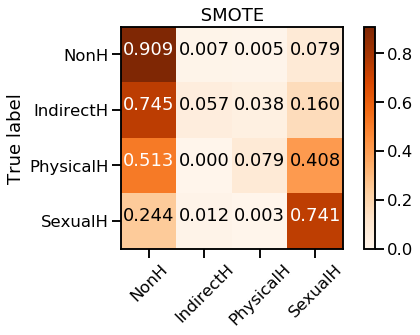

Test_ acc: 0.8097032501177579
Test_ f1 none: [0.893 0.094 0.126 0.658]
Test_ f1 macro: 0.442872368858267
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 19  ------------------- 



Accuracy sobre Test cnn1 : 0.7885068299576071
F1-score None sobre Test cnn1 : [0.879 0.046 0.212 0.642]
F1-score macro sobre Test cnn1 : 0.4449242585069182

Accuracy sobre Test cnn2 : 0.8134715025906736
F1-score None sobre Test cnn2 : [0.899 0.105 0.154 0.696]
F1-score macro sobre Test cnn2 : 0.46321154567030726

Accuracy sobre Test rnn1 : 0.5704192180876119
F1-score None sobre Test rnn1 : [0.726 0.154 0.098 0.453]
F1-score macro sobre Test rnn1 : 0.35781335268850656

Accuracy sobre Test rnn2 : 0.6142251530852567
F1-score None sobre Test rnn2 : [0.753 0.038 0.    0.4  ]
F1-score macro sobre Test rnn2 : 0.2977183603486393

Accuracy sobre Test rnn3 : 0.5836081017428167
F1-score None sobre Test rnn3 : [0.719 0.084 0.141 0.382]
F1-score macro sobre Test rnn3 : 0.33138503824

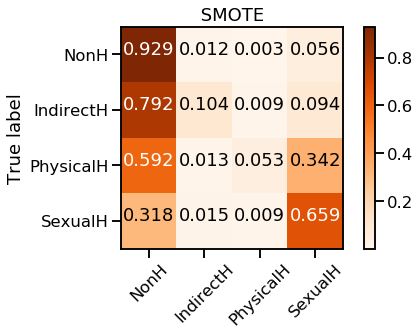

Test_ acc: 0.8130004710315591
Test_ f1 none: [0.894 0.154 0.09  0.65 ]
Test_ f1 macro: 0.4470968978356591
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 20  ------------------- 



Accuracy sobre Test cnn1 : 0.8068770607630711
F1-score None sobre Test cnn1 : [0.895 0.07  0.139 0.626]
F1-score macro sobre Test cnn1 : 0.43249103005023726

Accuracy sobre Test cnn2 : 0.7602449364107395
F1-score None sobre Test cnn2 : [0.862 0.084 0.124 0.627]
F1-score macro sobre Test cnn2 : 0.4240927192982236

Accuracy sobre Test rnn1 : 0.7206782854451248
F1-score None sobre Test rnn1 : [0.842 0.12  0.114 0.438]
F1-score macro sobre Test rnn1 : 0.3785433277756818

Accuracy sobre Test rnn2 : 0.29298162976919456
F1-score None sobre Test rnn2 : [0.338 0.062 0.009 0.343]
F1-score macro sobre Test rnn2 : 0.1877688487629031

Accuracy sobre Test rnn3 : 0.11917098445595854
F1-score None sobre Test rnn3 : [0.098 0.123 0.083 0.248]
F1-score macro sobre Test rnn3 : 0.137885970

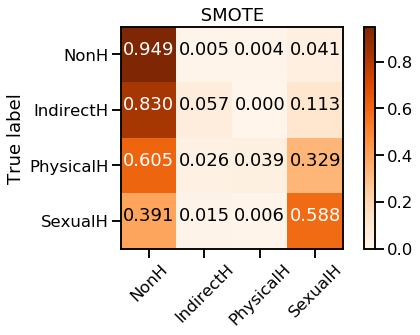

Test_ acc: 0.8144135657089024
Test_ f1 none: [0.897 0.094 0.068 0.622]
Test_ f1 macro: 0.4205096305359617


In [32]:
fs_macro, fs_none, accs, best_t, norm_t, vot_t, best_ma, glo_accs, glo_fno, glo_fma, glo_cms= train_5models_smote(7, 4, x_val, y_val, 1, 20, "Harassment", 26, "Oranges")

In [33]:
s=20.0

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("SMOTE - F1-score promedio para",key,":" , temp/s)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("SMOTE - F1-score macro promedio para",key,":" , temp/s, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("SMOTE - Accuracy promedio para",key,":", temp/s , "desvest: ",np.std(accs[key]))
    

SMOTE - F1-score promedio para cnn1 : [0.886 0.119 0.126 0.661]
SMOTE - F1-score promedio para cnn2 : [0.887 0.124 0.128 0.675]
SMOTE - F1-score promedio para rnn1 : [0.66  0.108 0.096 0.365]
SMOTE - F1-score promedio para rnn2 : [0.473 0.086 0.062 0.339]
SMOTE - F1-score promedio para rnn3 : [0.389 0.051 0.037 0.165]

SMOTE - F1-score macro promedio para cnn1 : 0.4480743052598751 desvest:  0.014332507898559343
SMOTE - F1-score macro promedio para cnn2 : 0.45358040522727394 desvest:  0.014613212723825583
SMOTE - F1-score macro promedio para rnn1 : 0.30739432953957757 desvest:  0.08684294924753605
SMOTE - F1-score macro promedio para rnn2 : 0.23991420116985335 desvest:  0.1139603005969431
SMOTE - F1-score macro promedio para rnn3 : 0.16040790540382538 desvest:  0.09755203833014074

SMOTE - Accuracy promedio para cnn1 : 0.7968205369759774 desvest:  0.012365161594932528
SMOTE - Accuracy promedio para cnn2 : 0.7999293452661328 desvest:  0.016276764571895593
SMOTE - Accuracy promedio para r

[TEST] Acc Best comité: 0.744  -- std: 0.022
[TEST] F1 macro Best comité: 0.431  -- std: 0.008
[TEST] F1-score NIPS Best comité: [0.853 0.169 0.146 0.556]


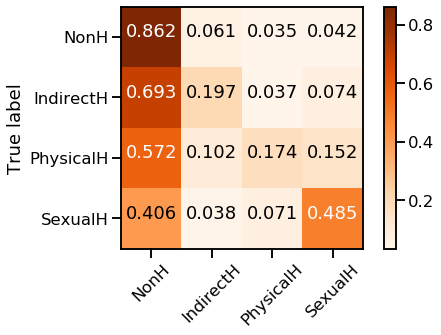

[TEST] Acc Norm comité: 0.821  -- std: 0.000
[TEST] F1 macro Norm comité: 0.422  -- std: 0.000
[TEST] F1-score NIPS Norm comité: [0.897 0.109 0.051 0.631]


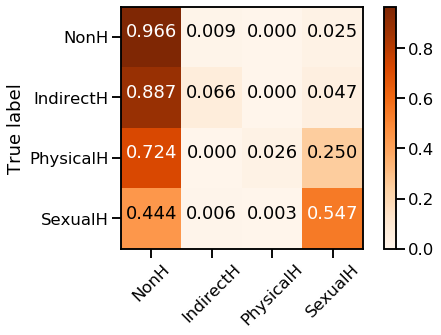

[TEST] Acc Voting comité: 0.819  -- std: 0.000
[TEST] F1 macro Voting comité: 0.426  -- std: 0.000
[TEST] F1-score NIPS Voting comité: [0.896 0.109 0.072 0.627]


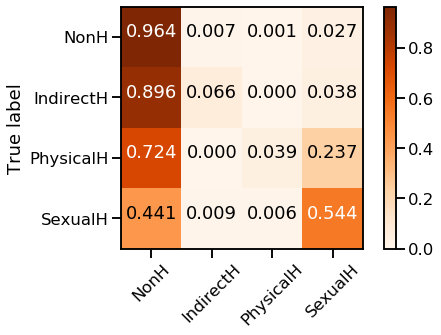

In [34]:
# best_t, norm_t, vot_t,

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_t['acc'])), " -- std: %.3f" % np.std(np.asarray(best_t['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_t['macro'])), " -- std: %.3f" % np.std(np.asarray(best_t['macro'])))
temp=np.zeros(4)
for result in best_t['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Best comité:" ,temp/s)

cm=np.zeros((4,4))
for result in best_t['cm']:
    cm+=result
plot_cm(cm_norma(cm), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='', cmap='Oranges')

print ("[TEST] Acc Norm comité: %.3f" % np.mean(np.asarray(norm_t['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_t['acc'])))
print ("[TEST] F1 macro Norm comité: %.3f" % np.mean(np.asarray(norm_t['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_t['macro'])))
temp=np.zeros(4)
for result in norm_t['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Norm comité:" ,temp/s)

cm=np.zeros((4,4))
for result in norm_t['cm']:
    cm+=result
plot_cm(cm_norma(cm), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='', cmap='Oranges')


print ("[TEST] Acc Voting comité: %.3f" % np.mean(np.asarray(vot_t['acc'])), " -- std: %.3f" % np.std(np.asarray(vot_t['acc'])))
print ("[TEST] F1 macro Voting comité: %.3f" % np.mean(np.asarray(vot_t['macro'])), " -- std: %.3f" % np.std(np.asarray(vot_t['macro'])))
temp=np.zeros(4)
for result in vot_t['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Voting comité:" ,temp/s)

cm=np.zeros((4,4))
for result in vot_t['cm']:
    cm+=result
plot_cm(cm_norma(cm), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='', cmap='Oranges')

In [35]:
print ("best_50", best_ma)
print ("all_accs_50", glo_accs)
print ("all_fno_50", glo_fno)
print ("all_ma_50", glo_fma)
# best_ma, glo_accs, glo_fno, glo_fma, glo_cms

best_50 {'F_ma': 0.4501907204532615, 'Run': 14}
all_accs_50 [0.8002826189354687, 0.7748469147432878, 0.7621290626471974, 0.80357983984927, 0.7781441356570891, 0.7630711257654262, 0.8097032501177579, 0.795572303344324, 0.7993405558172397, 0.8007536504945831, 0.8021667451719265, 0.7960433349034385, 0.765897315120113, 0.7724917569477155, 0.7800282618935469, 0.8115873763542157, 0.7880357983984927, 0.8097032501177579, 0.8130004710315591, 0.8144135657089024]
all_fno_50 [array([0.889, 0.14 , 0.087, 0.644]), array([0.869, 0.164, 0.078, 0.658]), array([0.862, 0.08 , 0.115, 0.596]), array([0.891, 0.17 , 0.086, 0.648]), array([0.874, 0.13 , 0.115, 0.637]), array([0.864, 0.131, 0.095, 0.649]), array([0.895, 0.125, 0.07 , 0.667]), array([0.885, 0.158, 0.063, 0.666]), array([0.889, 0.162, 0.024, 0.631]), array([0.893, 0.152, 0.113, 0.607]), array([0.889, 0.137, 0.045, 0.652]), array([0.888, 0.158, 0.059, 0.656]), array([0.864, 0.154, 0.085, 0.668]), array([0.868, 0.164, 0.127, 0.642]), array([0.873,

Acc: 0.792 -- deviation: 0.017
F-score: 0.436 -- deviation: 0.010
(SMOTE) NIPS: 0.882532706413541 0.13701806669753908 0.0793476736683373 0.6456132820207972


Confusion counts
[[2.860e+04 9.940e+02 2.420e+02 2.182e+03]
 [1.556e+03 2.540e+02 1.900e+01 2.910e+02]
 [7.760e+02 8.300e+01 7.900e+01 5.820e+02]
 [1.843e+03 1.900e+02 7.200e+01 4.695e+03]]


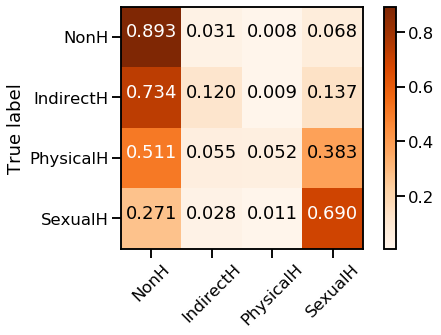

In [36]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(glo_accs)), "-- deviation: %.3f" % np.std(np.asarray(glo_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(glo_fma)), "-- deviation: %.3f" % np.std(np.asarray(glo_fma)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(glo_fno)[:,0])
den=np.mean(np.asarray(glo_fno)[:,1])
que=np.mean(np.asarray(glo_fno)[:,2])
com=np.mean(np.asarray(glo_fno)[:,3])

print ("(SMOTE) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in glo_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Oranges')